# LSTM - vanilla

In [1]:
best_model = "best_model2.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


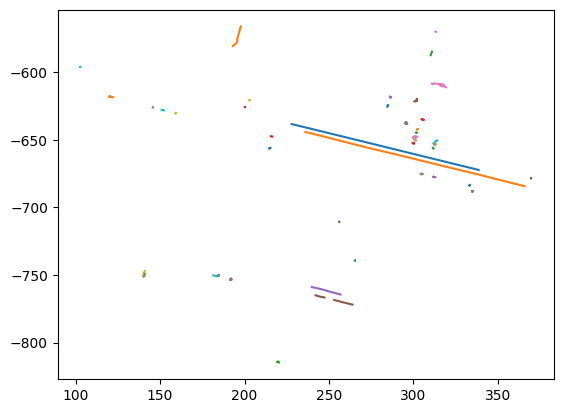

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [7]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [8]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [9]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=512, output_dim=60*2):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights properly
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        x = data.x[..., :4]
        x = x.reshape(-1, 50, 50, 4)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        # Process through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Extract final hidden state
        features = lstm_out[:, -1, :]
        
        # Process through prediction head
        features = self.relu(self.fc1(features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [10]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [11]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM(input_dim=4, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.01,  # Lower learning rate
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [ ]:
train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_28946/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_28946/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:08<14:02,  8.51s/epoch]

Epoch 000 | LR 0.009500 | Train MSE 2.0615 | Val MSE 0.4742 | Val MAE 3.0568 | Val MSE 23.2337
Sample pred first 3 steps: [[ 0.00575173  0.00966802]
 [-0.03109622  0.00472478]
 [-0.02798022  0.03648886]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 0.474158


Epoch:   2%|▏         | 2/100 [00:15<12:11,  7.47s/epoch]

Epoch 001 | LR 0.009025 | Train MSE 0.4222 | Val MSE 0.3606 | Val MAE 2.4660 | Val MSE 17.6701
Validation improved: 0.474158 -> 0.360614


Epoch:   3%|▎         | 3/100 [00:22<11:33,  7.15s/epoch]

Epoch 002 | LR 0.008574 | Train MSE 0.3643 | Val MSE 0.3611 | Val MAE 2.2729 | Val MSE 17.6943


Epoch:   4%|▍         | 4/100 [00:28<11:03,  6.91s/epoch]

Epoch 003 | LR 0.008145 | Train MSE 0.3432 | Val MSE 0.2766 | Val MAE 1.9427 | Val MSE 13.5513
Validation improved: 0.360614 -> 0.276556


Epoch:   5%|▌         | 5/100 [00:35<10:54,  6.88s/epoch]

Epoch 004 | LR 0.007738 | Train MSE 0.3252 | Val MSE 0.2785 | Val MAE 2.0553 | Val MSE 13.6460


Epoch:   6%|▌         | 6/100 [00:42<10:46,  6.88s/epoch]

Epoch 005 | LR 0.007351 | Train MSE 0.3114 | Val MSE 0.2782 | Val MAE 1.9545 | Val MSE 13.6325
Sample pred first 3 steps: [[-4.6998402e-04 -2.3793099e-03]
 [-1.7567333e-03  7.3445961e-05]
 [ 1.8781982e-04 -7.4702324e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:   7%|▋         | 7/100 [00:49<10:41,  6.90s/epoch]

Epoch 006 | LR 0.006983 | Train MSE 0.2885 | Val MSE 0.2748 | Val MAE 2.2229 | Val MSE 13.4638
Validation improved: 0.276556 -> 0.274772


Epoch:   8%|▊         | 8/100 [00:55<10:23,  6.78s/epoch]

Epoch 007 | LR 0.006634 | Train MSE 0.2771 | Val MSE 0.2350 | Val MAE 1.8694 | Val MSE 11.5144
Validation improved: 0.274772 -> 0.234988


Epoch:   9%|▉         | 9/100 [01:02<10:09,  6.70s/epoch]

Epoch 008 | LR 0.006302 | Train MSE 0.2721 | Val MSE 0.2462 | Val MAE 1.9729 | Val MSE 12.0656


Epoch:  10%|█         | 10/100 [01:08<10:00,  6.67s/epoch]

Epoch 009 | LR 0.005987 | Train MSE 0.2606 | Val MSE 0.2279 | Val MAE 1.8282 | Val MSE 11.1648
Validation improved: 0.234988 -> 0.227854


Epoch:  11%|█         | 11/100 [01:15<09:57,  6.71s/epoch]

Epoch 010 | LR 0.005688 | Train MSE 0.2608 | Val MSE 0.2254 | Val MAE 1.8214 | Val MSE 11.0426
Sample pred first 3 steps: [[0.00172885 0.00148868]
 [0.00502335 0.00240451]
 [0.0033188  0.01067907]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.227854 -> 0.225360


Epoch:  12%|█▏        | 12/100 [01:22<09:58,  6.80s/epoch]

Epoch 011 | LR 0.005404 | Train MSE 0.2472 | Val MSE 0.2049 | Val MAE 1.6844 | Val MSE 10.0378
Validation improved: 0.225360 -> 0.204854


Epoch:  13%|█▎        | 13/100 [01:29<09:54,  6.83s/epoch]

Epoch 012 | LR 0.005133 | Train MSE 0.2409 | Val MSE 0.2127 | Val MAE 1.7114 | Val MSE 10.4210


Epoch:  14%|█▍        | 14/100 [01:36<09:59,  6.97s/epoch]

Epoch 013 | LR 0.004877 | Train MSE 0.2409 | Val MSE 0.2078 | Val MAE 1.6507 | Val MSE 10.1830


Epoch:  15%|█▌        | 15/100 [01:43<09:54,  7.00s/epoch]

Epoch 014 | LR 0.004633 | Train MSE 0.2347 | Val MSE 0.2068 | Val MAE 1.7183 | Val MSE 10.1344


Epoch:  16%|█▌        | 16/100 [01:50<09:45,  6.97s/epoch]

Epoch 015 | LR 0.004401 | Train MSE 0.2330 | Val MSE 0.2142 | Val MAE 1.6927 | Val MSE 10.4961
Sample pred first 3 steps: [[-1.8497852e-03  1.1395487e-03]
 [-1.9617206e-03  4.7805449e-03]
 [-2.3049302e-05  2.8086067e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  17%|█▋        | 17/100 [01:57<09:29,  6.86s/epoch]

Epoch 016 | LR 0.004181 | Train MSE 0.2339 | Val MSE 0.1868 | Val MAE 1.4733 | Val MSE 9.1543
Validation improved: 0.204854 -> 0.186822


Epoch:  18%|█▊        | 18/100 [02:03<09:14,  6.76s/epoch]

Epoch 017 | LR 0.003972 | Train MSE 0.2310 | Val MSE 0.2004 | Val MAE 1.7023 | Val MSE 9.8214


Epoch:  19%|█▉        | 19/100 [02:10<09:01,  6.68s/epoch]

Epoch 018 | LR 0.003774 | Train MSE 0.2268 | Val MSE 0.1854 | Val MAE 1.5200 | Val MSE 9.0852
Validation improved: 0.186822 -> 0.185413


Epoch:  20%|██        | 20/100 [02:17<08:52,  6.66s/epoch]

Epoch 019 | LR 0.003585 | Train MSE 0.2204 | Val MSE 0.1914 | Val MAE 1.5732 | Val MSE 9.3762


Epoch:  21%|██        | 21/100 [02:23<08:44,  6.64s/epoch]

Epoch 020 | LR 0.003406 | Train MSE 0.2252 | Val MSE 0.1877 | Val MAE 1.5553 | Val MSE 9.1963
Sample pred first 3 steps: [[-0.00034093  0.00187799]
 [ 0.00514104 -0.00057867]
 [ 0.0040519  -0.00107233]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  22%|██▏       | 22/100 [02:30<08:48,  6.78s/epoch]

Epoch 021 | LR 0.003235 | Train MSE 0.2192 | Val MSE 0.1895 | Val MAE 1.5586 | Val MSE 9.2869


Epoch:  23%|██▎       | 23/100 [02:37<08:51,  6.90s/epoch]

Epoch 022 | LR 0.003074 | Train MSE 0.2192 | Val MSE 0.1887 | Val MAE 1.5128 | Val MSE 9.2447


Epoch:  24%|██▍       | 24/100 [02:44<08:45,  6.92s/epoch]

Epoch 023 | LR 0.002920 | Train MSE 0.2193 | Val MSE 0.1934 | Val MAE 1.5407 | Val MSE 9.4768


Epoch:  25%|██▌       | 25/100 [02:52<08:43,  6.98s/epoch]

Epoch 024 | LR 0.002774 | Train MSE 0.2155 | Val MSE 0.2006 | Val MAE 1.6443 | Val MSE 9.8298


Epoch:  26%|██▌       | 26/100 [02:58<08:32,  6.93s/epoch]

Epoch 025 | LR 0.002635 | Train MSE 0.2135 | Val MSE 0.1832 | Val MAE 1.4839 | Val MSE 8.9750
Sample pred first 3 steps: [[ 0.00173975 -0.00220528]
 [ 0.00318256 -0.00352367]
 [ 0.00480814 -0.00368191]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.185413 -> 0.183164


Epoch:  27%|██▋       | 27/100 [03:05<08:23,  6.89s/epoch]

Epoch 026 | LR 0.002503 | Train MSE 0.2075 | Val MSE 0.1991 | Val MAE 1.5499 | Val MSE 9.7545


Epoch:  28%|██▊       | 28/100 [03:11<07:48,  6.51s/epoch]

Epoch 027 | LR 0.002378 | Train MSE 0.2154 | Val MSE 0.1806 | Val MAE 1.4375 | Val MSE 8.8511
Validation improved: 0.183164 -> 0.180635


Epoch:  29%|██▉       | 29/100 [03:17<07:29,  6.33s/epoch]

Epoch 028 | LR 0.002259 | Train MSE 0.2079 | Val MSE 0.1765 | Val MAE 1.4476 | Val MSE 8.6490
Validation improved: 0.180635 -> 0.176511


Epoch:  30%|███       | 30/100 [03:23<07:15,  6.23s/epoch]

Epoch 029 | LR 0.002146 | Train MSE 0.2088 | Val MSE 0.1795 | Val MAE 1.4077 | Val MSE 8.7940


Epoch:  31%|███       | 31/100 [03:29<07:02,  6.12s/epoch]

Epoch 030 | LR 0.002039 | Train MSE 0.2064 | Val MSE 0.1895 | Val MAE 1.5203 | Val MSE 9.2851
Sample pred first 3 steps: [[-0.00088989 -0.0005555 ]
 [-0.00298937 -0.00413689]
 [-0.00515097 -0.00594141]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  32%|███▏      | 32/100 [03:34<06:44,  5.94s/epoch]

Epoch 031 | LR 0.001937 | Train MSE 0.2092 | Val MSE 0.1832 | Val MAE 1.5101 | Val MSE 8.9758


Epoch:  33%|███▎      | 33/100 [03:40<06:31,  5.84s/epoch]

Epoch 032 | LR 0.001840 | Train MSE 0.2057 | Val MSE 0.1843 | Val MAE 1.4695 | Val MSE 9.0294


Epoch:  34%|███▍      | 34/100 [03:45<06:18,  5.74s/epoch]

Epoch 033 | LR 0.001748 | Train MSE 0.2039 | Val MSE 0.1777 | Val MAE 1.4514 | Val MSE 8.7077


Epoch:  35%|███▌      | 35/100 [03:51<06:06,  5.64s/epoch]

Epoch 034 | LR 0.001661 | Train MSE 0.2019 | Val MSE 0.1726 | Val MAE 1.3961 | Val MSE 8.4592
Validation improved: 0.176511 -> 0.172638


Epoch:  36%|███▌      | 36/100 [03:56<05:57,  5.58s/epoch]

Epoch 035 | LR 0.001578 | Train MSE 0.2009 | Val MSE 0.1740 | Val MAE 1.4505 | Val MSE 8.5247
Sample pred first 3 steps: [[-0.00018525 -0.00116561]
 [ 0.00170998 -0.00058822]
 [ 0.00348494  0.00148263]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  37%|███▋      | 37/100 [04:01<05:46,  5.50s/epoch]

Epoch 036 | LR 0.001499 | Train MSE 0.1978 | Val MSE 0.1790 | Val MAE 1.5500 | Val MSE 8.7710


Epoch:  38%|███▊      | 38/100 [04:07<05:38,  5.46s/epoch]

Epoch 037 | LR 0.001424 | Train MSE 0.2002 | Val MSE 0.1783 | Val MAE 1.4721 | Val MSE 8.7374


Epoch:  39%|███▉      | 39/100 [04:12<05:26,  5.36s/epoch]

Epoch 038 | LR 0.001353 | Train MSE 0.1986 | Val MSE 0.1735 | Val MAE 1.4228 | Val MSE 8.5018


Epoch:  40%|████      | 40/100 [04:17<05:22,  5.38s/epoch]

Epoch 039 | LR 0.001285 | Train MSE 0.1979 | Val MSE 0.1720 | Val MAE 1.4175 | Val MSE 8.4299
Validation improved: 0.172638 -> 0.172039


Epoch:  41%|████      | 41/100 [04:23<05:31,  5.61s/epoch]

Epoch 040 | LR 0.001221 | Train MSE 0.1975 | Val MSE 0.1725 | Val MAE 1.3865 | Val MSE 8.4534
Sample pred first 3 steps: [[0.00036736 0.00178782]
 [0.00022644 0.00292497]
 [0.00138285 0.00324379]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  42%|████▏     | 42/100 [04:29<05:29,  5.68s/epoch]

Epoch 041 | LR 0.001160 | Train MSE 0.1948 | Val MSE 0.1761 | Val MAE 1.4378 | Val MSE 8.6269


Epoch:  43%|████▎     | 43/100 [04:36<05:44,  6.04s/epoch]

Epoch 042 | LR 0.001102 | Train MSE 0.1958 | Val MSE 0.1709 | Val MAE 1.4096 | Val MSE 8.3722
Validation improved: 0.172039 -> 0.170861


Epoch:  44%|████▍     | 44/100 [04:43<05:49,  6.23s/epoch]

Epoch 043 | LR 0.001047 | Train MSE 0.1957 | Val MSE 0.1702 | Val MAE 1.3657 | Val MSE 8.3381
Validation improved: 0.170861 -> 0.170165


Epoch:  45%|████▌     | 45/100 [04:50<05:56,  6.48s/epoch]

Epoch 044 | LR 0.000994 | Train MSE 0.1927 | Val MSE 0.1715 | Val MAE 1.3981 | Val MSE 8.4030


Epoch:  46%|████▌     | 46/100 [04:57<05:54,  6.57s/epoch]

Epoch 045 | LR 0.000945 | Train MSE 0.1935 | Val MSE 0.1704 | Val MAE 1.4033 | Val MSE 8.3519
Sample pred first 3 steps: [[ 0.00148346 -0.00098821]
 [ 0.00257357 -0.0005536 ]
 [ 0.00354352 -0.00094767]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  47%|████▋     | 47/100 [05:03<05:51,  6.64s/epoch]

Epoch 046 | LR 0.000897 | Train MSE 0.1913 | Val MSE 0.1705 | Val MAE 1.3843 | Val MSE 8.3548


Epoch:  48%|████▊     | 48/100 [05:10<05:43,  6.61s/epoch]

Epoch 047 | LR 0.000853 | Train MSE 0.1930 | Val MSE 0.1740 | Val MAE 1.4164 | Val MSE 8.5273


Epoch:  49%|████▉     | 49/100 [05:16<05:34,  6.56s/epoch]

Epoch 048 | LR 0.000810 | Train MSE 0.1932 | Val MSE 0.1710 | Val MAE 1.3784 | Val MSE 8.3787


Epoch:  50%|█████     | 50/100 [05:23<05:25,  6.51s/epoch]

Epoch 049 | LR 0.000769 | Train MSE 0.1894 | Val MSE 0.1695 | Val MAE 1.3503 | Val MSE 8.3041
Validation improved: 0.170165 -> 0.169472


Epoch:  51%|█████     | 51/100 [05:30<05:24,  6.61s/epoch]

Epoch 050 | LR 0.000731 | Train MSE 0.1905 | Val MSE 0.1678 | Val MAE 1.3478 | Val MSE 8.2205
Sample pred first 3 steps: [[ 0.0010706   0.00044944]
 [ 0.00307206  0.00068695]
 [ 0.00374786 -0.00015742]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.169472 -> 0.167765


Epoch:  52%|█████▏    | 52/100 [05:37<05:22,  6.72s/epoch]

Epoch 051 | LR 0.000694 | Train MSE 0.1893 | Val MSE 0.1661 | Val MAE 1.3364 | Val MSE 8.1405
Validation improved: 0.167765 -> 0.166133


Epoch:  53%|█████▎    | 53/100 [05:44<05:18,  6.78s/epoch]

Epoch 052 | LR 0.000660 | Train MSE 0.1902 | Val MSE 0.1671 | Val MAE 1.3267 | Val MSE 8.1882


# Final Pred

In [13]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto7.csv', index=True)